## Essencial Functions and Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tifffile import imread
from sklearn.model_selection import train_test_split

# Main directory
dataset_dir        = 'spotlite_dataset_loca1_date1_dir1'
images_dataset_dir = os.path.join(dataset_dir, 'images')
masks_dataset_dir  = os.path.join(dataset_dir, 'masks')

# ------------- Auxiliary Functions ------------- #

def load_dataset(images_dir, masks_dir, img_files=None, msk_files=None):
    """
    Loads only the listed files (or the entire directory if None).
    Returns:
      imgs: (N, H, W, C)
      msks: (N, H, W)
    """
    if img_files is None:
        img_files = sorted([f for f in os.listdir(images_dir)
                            if f.endswith('.tif') and not f.endswith('_mask.tif')])
    if msk_files is None:
        msk_files = sorted([f for f in os.listdir(masks_dir)
                            if f.endswith('_mask.tif')])

    img_bases = {os.path.splitext(f)[0]: f for f in img_files}
    msk_bases = {os.path.splitext(f)[0].replace('_mask',''): f for f in msk_files}
    common = sorted(set(img_bases) & set(msk_bases))

    imgs, msks = [], []
    for base in common:
        img = imread(os.path.join(images_dir, img_bases[base]))
        msk = imread(os.path.join(masks_dir,  msk_bases[base]))
        # Ensure HWC format
        if img.ndim == 3 and img.shape[0] in (3,4):
            img = img.transpose(1,2,0)
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        imgs.append(img)
        msks.append(msk)

    return np.stack(imgs, axis=0), np.stack(msks, axis=0)

def remap_mask(mask):
    """From 0,3,4 → 0,1,2"""
    out = np.zeros_like(mask, dtype=np.uint8)
    out[mask == 3] = 1
    out[mask == 4] = 2
    return out

## Check inbalance before undersampling

🔍 Distribution BEFORE undersampling:
 class     counts   percent
     0 1172379257 99.827499
     3     687567  0.058546
     4    1338296  0.113955


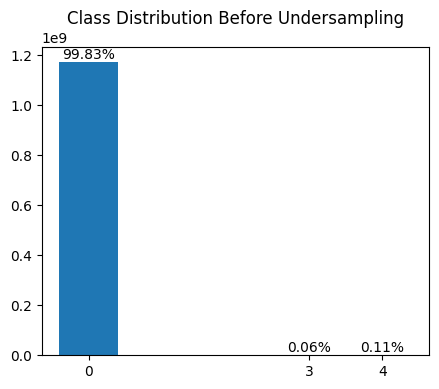

In [3]:
masks_dataset_dir = 'spotlite_dataset_loca1_date1_dir1/masks'

mask_files = sorted(
    f for f in os.listdir(masks_dataset_dir)
    if f.endswith('_mask.tif')
)

class_counts = {}
total_pixels = 0

for mf in mask_files:
    mask = imread(os.path.join(masks_dataset_dir, mf))
    unique, counts = np.unique(mask, return_counts=True)
    for u, c in zip(unique, counts):
        class_counts[u] = class_counts.get(u, 0) + int(c)
    total_pixels += mask.size

df_before = pd.DataFrame([
    {'class': cls, 'counts': cnt, 'percent': cnt/total_pixels*100}
    for cls, cnt in sorted(class_counts.items())
])

print("🔍 Distribution BEFORE undersampling:")
print(df_before.to_string(index=False))

fig, ax = plt.subplots(figsize=(5,4))
bars = ax.bar(df_before['class'], df_before['counts'])
ax.set_xticks(df_before['class'])
ax.set_xticklabels([f"{c}" for c in df_before['class']])
for bar, pct in zip(bars, df_before['percent']):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height(), f"{pct:.2f}%", 
            ha='center', va='bottom')
ax.set_title("Class Distribution Before Undersampling")
plt.show()


## Balance Patches

Now that we have all the patches in `imgs, masks`, let's:
1. Separate patches that are 100% background (`mask==0`) from patches "with trees".  
2. Keep **all** non-empty patches and only a fraction of the empty ones (e.g., 10%).  
3. Reload only these balanced patches.

In [ ]:

# 1) Identify how many patches are 100% background and how many have at least one tree pixel
N = len(mask_files)
bg_idxs = []
nb_idxs = []
for idx, mf in enumerate(mask_files):
    mask = imread(os.path.join(masks_dataset_dir, mf))
    if np.all(mask == 0):
        bg_idxs.append(idx)
    else:
        nb_idxs.append(idx)

print(f"{len(bg_idxs)} empty patches, {len(nb_idxs)} non-empty patches")

# 2) Undersample the empty patches (keep only 10%)
frac_empty = 0.1
keep_bg = random.sample(bg_idxs, int(len(bg_idxs) * frac_empty))
keep_idxs = sorted(nb_idxs + keep_bg)

bases = [os.path.splitext(mf)[0].replace('_mask', '') for mf in mask_files]
image_files = [base + '.tif' for base in bases]

sel_img_files = [image_files[i] for i in keep_idxs]
sel_msk_files = [mask_files[i] for i in keep_idxs]

print(f"Selected {len(sel_img_files)} patches for training")


## Convert labels

In [ ]:
# Convert labels in masks from 0, 3, 4 to 0, 1, 2
def remap_mask(mask):
    out = np.zeros_like(mask, dtype=np.uint8)
    out[mask == 3] = 1
    out[mask == 4] = 2
    return out

# reload only selected, remap in-place
imgs_sel, masks_sel = load_dataset(
    images_dataset_dir,
    masks_dataset_dir,
    img_files=sel_img_files,
    msk_files=sel_msk_files
)
masks_sel = remap_mask(masks_sel)
print(f'selected imgs.shape = {imgs_sel.shape}')
print(f'selected masks.shape= {masks_sel.shape}')
print("Unique values in selected masks:", np.unique(masks_sel))

## Check Inbalance

In [ ]:
total_pixels = y.size
classes, counts = np.unique(y, return_counts=True)
df_dist = pd.DataFrame({"class":classes,"counts":counts})
df_dist["percent"] = df_dist["counts"]/total_pixels*100
print(df_dist)

class_names = {0:"background",1:"pinus",2:"eucalyptus"}
labels = [f"{r['class']}-{class_names[r['class']]}" for _,r in df_dist.iterrows()]
fig, ax = plt.subplots()
bars = ax.bar(df_dist['class'], df_dist['counts'])
ax.set_xticks(df_dist['class']); ax.set_xticklabels(labels)
for bar,pct in zip(bars, df_dist['percent']):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height(), f"{pct:.2f}%", ha='center')
plt.show()

## Load Selected Patches for Training

In [ ]:

# Carrega apenas os patches que escolhemos
imgs_sel, masks_sel = load_dataset(
    images_dataset_dir,
    masks_dataset_dir,
    img_files=sel_img_files,
    msk_files=sel_msk_files
)

# Remapeia de (0,3,4) → (0,1,2)
masks_sel = remap_mask(masks_sel)

print(f"Selected imgs shape: {imgs_sel.shape}  (N,H,W,C)")
print(f"Selected masks shape: {masks_sel.shape} (N,H,W)")
print("Unique in selected masks:", np.unique(masks_sel))

## Extract Features, Check Balance, Split

In [ ]:
# 1) Extract X and y
N, H, W, C = imgs_sel.shape
X = imgs_sel.reshape(-1, C)
y = masks_sel.reshape(-1)

# 2) Check distribution after undersampling
total_pixels = y.size
classes, counts = np.unique(y, return_counts=True)
df_dist = pd.DataFrame({"class": classes, "counts": counts})
df_dist["percent"] = df_dist["counts"] / total_pixels * 100

print("🔍 Distribution AFTER undersampling:")
print(df_dist.to_string(index=False))

# Bar plot
class_names = {0: "background", 1: "pinus", 2: "eucalyptus"}
labels = [f"{r['class']}-{class_names[r['class']]}" for _, r in df_dist.iterrows()]

fig, ax = plt.subplots()
bars = ax.bar(df_dist['class'], df_dist['counts'])
ax.set_xticks(df_dist['class'])
ax.set_xticklabels(labels)
for bar, pct in zip(bars, df_dist['percent']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{pct:.2f}%", ha='center')
plt.title("Class Distribution After Undersampling")
plt.show()

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

shape of X_train: (37552128, 4)
shape of y_train: (37552128,)
shape of X_test: (12517376, 4)
shape of y_test: (12517376,)


### Train Random Forest 

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

def train_two_stage_rf(X, y, forest_params, species_params):
  # Stage 1: background (0) vs forest (1)
  y_forest = (y > 0).astype(int)
  forest_clf = RandomForestClassifier(**forest_params)
  forest_clf.fit(X, y_forest)

  # Stage 2: pinus (1) vs eucalyptus (2) only in forest pixels
  mask_f = (y > 0)
  X_fg, y_fg = X[mask_f], y[mask_f]
  species_clf = RandomForestClassifier(**species_params)
  species_clf.fit(X_fg, y_fg)

  return forest_clf, species_clf

def predict_two_stage_rf(forest_clf, species_clf, X):
  is_forest = forest_clf.predict(X).astype(bool)
  y_pred = np.zeros(X.shape[0], dtype=int)
  if is_forest.any():
    y_pred[is_forest] = species_clf.predict(X[is_forest])
  return y_pred

# --- balanced parameters ---
forest_params = {
  'n_estimators': 50, 'max_depth': 20,
  'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 42
}
species_params = {
  'n_estimators': 50, 'max_depth': 20,
  'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 42
}

# 1) Train using only X_train, y_train
forest_clf, species_clf = train_two_stage_rf(
  X_train, y_train,
  forest_params, species_params
)

# 2) Full prediction
y_pred_full = predict_two_stage_rf(forest_clf, species_clf, X_test)

# 3) Evaluation of Stage 1
y_forest_true = (y_test > 0).astype(int)
y_forest_pred = forest_clf.predict(X_test)
print("=== Stage 1: Background vs. Forest ===")
print(classification_report(
  y_forest_true, y_forest_pred,
  target_names=['Background', 'Forest'], digits=4
))

# 4) Evaluation of Stage 2 (isolated, only in REAL forest pixels)
X_test_fg = X_test[y_test > 0]
y_test_fg = y_test[y_test > 0]
y_pred_fg = species_clf.predict(X_test_fg)
print("=== Stage 2: Pinus vs. Eucalyptus (isolated evaluation) ===")
print(classification_report(
  y_test_fg, y_pred_fg,
  target_names=['Pinus', 'Eucalyptus'], digits=4
))

# 5) Full pipeline evaluation
print("=== Full Pipeline (3 classes) ===")
print(classification_report(
  y_test, y_pred_full,
  target_names=['Background', 'Pinus', 'Eucalyptus'], digits=4
))

=== Stage 1: Background vs. Forest ===
              precision    recall  f1-score   support

  Background     0.9932    0.8648    0.9246  12010910
      Forest     0.2114    0.8593    0.3393    506466

    accuracy                         0.8646  12517376
   macro avg     0.6023    0.8621    0.6319  12517376
weighted avg     0.9616    0.8646    0.9009  12517376

=== Stage 2: Pinus vs. Eucalyptus (isolated evaluation) ===
              precision    recall  f1-score   support

       Pinus     0.9621    0.9303    0.9459    171892
  Eucalyptus     0.9648    0.9812    0.9729    334574

    accuracy                         0.9639    506466
   macro avg     0.9634    0.9557    0.9594    506466
weighted avg     0.9639    0.9639    0.9638    506466

=== Full Pipeline (3 classes) ===
              precision    recall  f1-score   support

  Background     0.9932    0.8648    0.9246  12010910
       Pinus     0.0953    0.6510    0.1663    171892
  Eucalyptus     0.3510    0.9282    0.5094    334

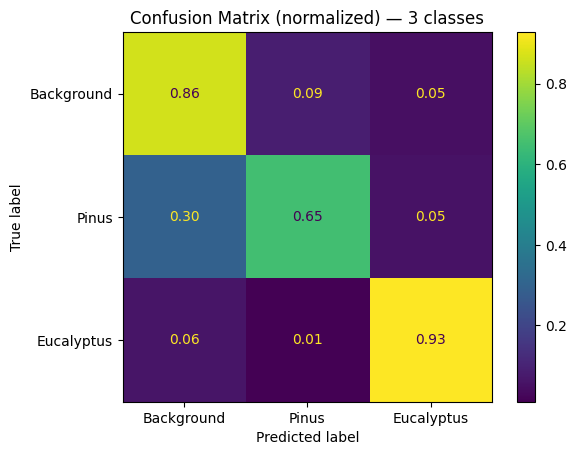

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_full,
    normalize='true',
    display_labels=['Background','Pinus','Eucalyptus'],
    values_format='.2f'
)
plt.title("Confusion Matrix (normalized) — 3 classes")
plt.show()